# Toy house price prediction example.

### This notebook contains the code to train a neural network to predict the price of a house based on its condition (condition is a 1-10 rating). This is soley to demonstrate how a neural network can approximate a non-linear function; the results are not going to be useful or even impressive in any real use case.

## Import libraries

In [3]:
from csv import reader
import numpy as np
import torch
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display

## Configure MatPlotLib

**We'll be using MatPlotLib to plot our dataset and training results. Here we'll do some basic setup**

In [2]:
# Makes the MPL graphs display in the notebook properly
%matplotlib inline
plt.rcParams["axes.grid"] = False  # Turn off gridlines on the graphs
plt.rcParams['figure.figsize'] = [15, 10]  # Sets the default size of the graphs to be more reasonable

## Load our dataset

**We have a CSV file in the local directory containing the training data we will be using for this example. The data contains two columns; the first is the quality of the home, and the second is the sale price. The CSV also has a header for the first row, so we will `pop()` that off.**

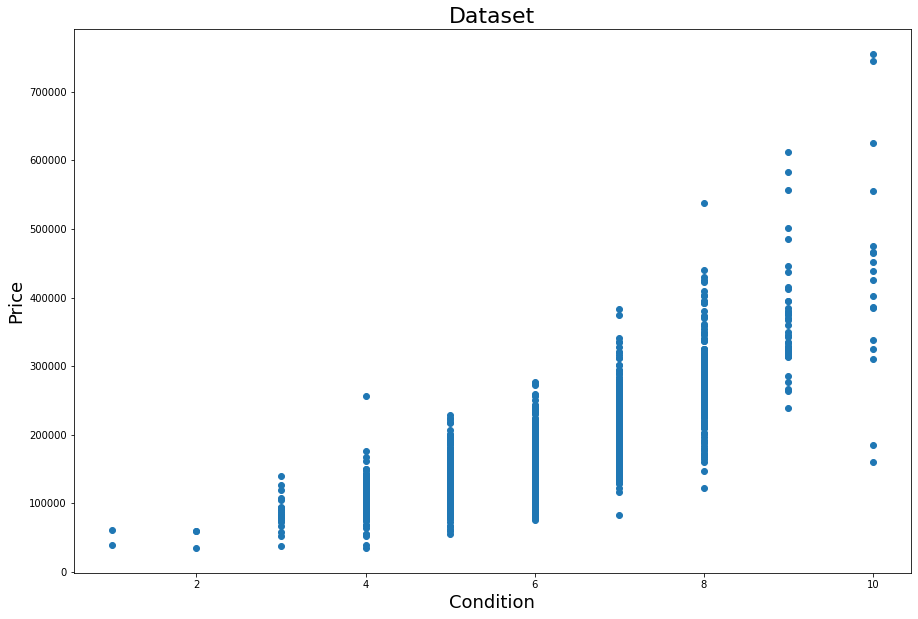

In [3]:
with open('./nn.svg', 'r') as file:
    svg_string = file.read()

with open('dataset.csv') as file:
    data = list(reader(file))
data.pop(0)  # Remove header
data = [[int(x[0]), int(x[1])] for x in data]  # Convert the string data into integers

# Go ahead and randomly shuffle the date.  This is 
# important for ML training. Ideally, we would also
# shuffle the data every epoch during training, but
# for this example we will just shuffle once.
shuffle(data)

train_data = np.array(data)
train_x = train_data[:, 0].astype(np.float32)
train_y = train_data[:, 1].astype(np.float32)
train_x_max = train_x.max()
train_y_max = train_y.max()

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('Price', fontsize=18)
ax.set_xlabel('Condition', fontsize=18)
ax.set_title('Dataset', fontsize=22)
ax.scatter(train_x, train_y)

## Define some pre/post processing functions for our data. These are going to be used a lot during training, so we will break them out into reusable functions.

In [4]:
def pre_process_input(value, range_max):
    # Wrap our x value in a torch.Tensor and cast it to a
    # 32 bit float. The model's parameters are float32, and
    # we need to match our input datatype to the model's.
    if isinstance(value, np.ndarray):
        tensor = torch.from_numpy(value, dtype=torch.float32)
    else:
        tensor = torch.tensor(value, dtype=torch.float32)
    # Scale our x value into a 0:1 range, then normalize
    # with a mean and standard deviation of 0.5. This will
    # put the value into a -1:1 range which is a nice input
    # for our neural net.
    tensor = ((tensor / range_max) - 0.5) / 0.5
    # When training neural networks, it is very common
    # to run multiple training examples through the network
    # together and do a single update to our network based
    # on the average gradients across the "mini-batch". For
    # this example, we won't use a batch, but the model expects
    # the input to have an extra batch dimension, so we will
    # add a fake one with unsqueeze_()
    tensor.unsqueeze_(0)
    return tensor

    
def post_process_prediction(prediction, range_max):
    prediction.squeeze_(0)  # Remove the fake "batch" dimension
    # Denormalize the prediction and scale it back into the original range
    prediction = ((prediction + 1) / 2.0) * range_max
    # The prediction is a torch.Tensor currenty, and we want to grab the
    # singe sale price value from that tensor as a float, then cast it to
    # an integer. We can get the float value of the tensor using the item()
    # method.
    prediction_int = int(prediction.item())
    return prediction_int

## Construct our neural network

**Funny enough, this is going to be the easiest step in this process. The network we are going to use is extremely simple. It's a multilayer perceptron with one input node, one output node, and a hidden layer with 10 units. In total our model has 31 trainable parameters. We use a *Rectified Linear Unit* (ReLU) activation function which is literally just a high-pass filter. If a value is above 0, it is passed throught the function untouched. If the value is below zero, it is simply set to 0.**

**In the code below, you can see how ML libraries like PyTorch leverage the concept of layers. We create our first set of weights using the `Linear` class, which in our case defines 1 input node fully connected to 10 output nodes. We then flow those 10 outputs through our ReLU activation function. After activation, we followed with another `Linear` layer which maps our 10 nodes down to our single output node for our network. In this way we can define a model that looks like this:**

![nn_graph](./nn_small.png)

In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        """
        This is where we will actually create the components for our network.
        PyTorch generally follows a design pattern of "create the parts" (that's here)
        then "define how the data flows through those parts" (the forward method below).
        """
        
        self.layer_1: torch.nn.Module = torch.nn.Linear(1, 10)
        self.activation = torch.nn.ReLU()
        self.layer_2 = torch.nn.Linear(10, 1)
                
    def forward(self, x):
        
        """
        When using PyTorch, the `forward` method is implemented to
        define the data flow of the network. In the case of this net,
        we are just going to flow sequentially through the layers defined
        in the constructor above.
        """
        
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        return x
    
model = Model()

## Construct our optimizer

**Our optimizer is the thing that is actually going to "turn the knobs" inside our network. In the training loop below, we will calculate the loss for a training sample. Once we have the loss, we will back propagate that loss to get a gradient for each parameter. The gradients represent "in what direction should this parameter move to reduce the loss? And how much should it move?"**

**The optimizer will look at the gradients and tweak each model parameter accordingly. We have a learning rate parameter for the optimizer that can scale the magnitude of the weight change as well. If the learning rate is too high, the weight updates will be huge and the model won't actually learn. If it's too low, the model will learn too slowly and could get stuck in a local minimum. This isn't a huge concern for this simple example, and we'll just pick a nice middle-ground value**

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.7)

## Train the model

**Now it's time to train our neural network. In ML, when you have trained the model on all the samples in the dataset, you have completed an *epoch*. Our model will train for 200 epochs, or 200 passes through the dataset.**

KeyboardInterrupt: 

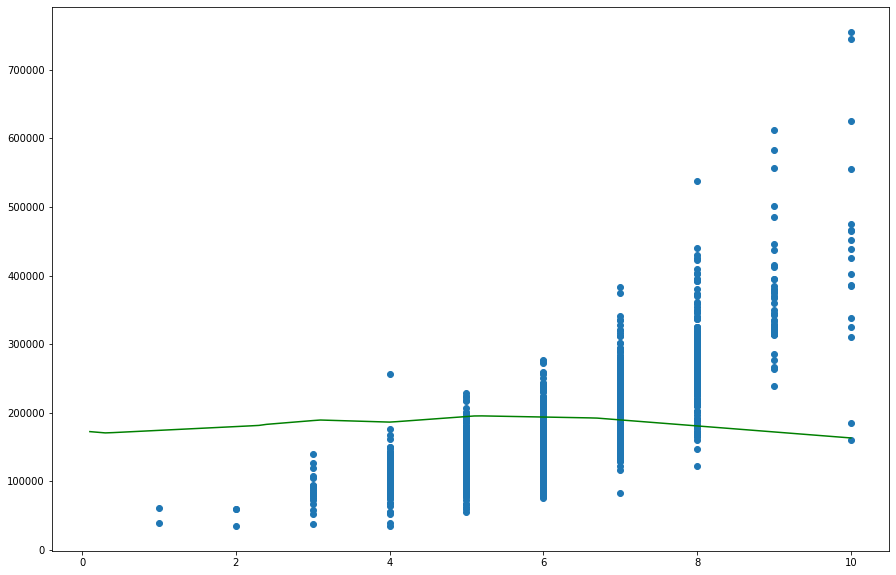

In [7]:
# Set up our graph
fig = plt.figure()
ax = plt.axes()

for epoch in range(200):
    
    # This is our actual training loop. We will take our training sample,
    # do some normalization on it, then pass it through the model to get a
    # prediction. Once we have a prediction, we compare it to the actual value
    # in the dataset to find out how far off our model was. That value is the loss.
    # we will call backward() on that loss tensor, which performs back propagation.
    # Once we call backward, we can tell our optimizer to update the weights.
    for i, (x, y) in enumerate(zip(train_x, train_y)):
        # Prepare our training sample
        x_tensor = pre_process_input(x, train_x_max)
        y_tensor = pre_process_input(y, train_y_max)
        # Get a prediction!
        prediction = model(x_tensor)
        # Find out how wrong was our not-so-smart neural network was.
        loss = torch.nn.functional.mse_loss(prediction, y_tensor)
        # This is a little trick that is not really advised for real world use.
        # Since we only have a few datapoints representing the 1 and 2 quality
        # ratings, we are going to manually scale the loss if we come across those
        # samples. We do this to correct the imbalance. By scaling the loss, we 
        # can force these underrepresented samples to be more significant.
        if x == 1.0 or x == 2.0:
            loss = loss * 20.0

        optimizer.zero_grad()  # Clear out the gradients from the last training step
        loss.backward()  # Get some fresh gradients from our new loss
        optimizer.step()  # Update the weights of the network
        
        if i % 100 == 0:
            # Plot the model's predictions. We are just going to generate a 
            # spread of house condition values, ranging from 1-10 and predict a
            # price for each one. The idea here is to plot a line across the data
            # that properly fits throught the center of each grouping of values.
            # as the model trains, the line should begin to fit tighter and tighter
            # to the training data.
            predicted_data = []
            # Get a bunch of predictions
            for x in range(1, 101):
                # Scale the inputs from 1 to 100 down to 1-10, with
                # 100 increments in the range. This helps us draw a smooth
                # line representing the network's learned function.
                x /= 10
                # Prepare our data for input to the network
                x_tensor = pre_process_input(x, train_x_max)
                # Forward pass through the model
                raw_prediction = model(x_tensor)
                # Scale our output back into the range of the raw dataset
                processed_prediction = post_process_prediction(raw_prediction, train_y_max)
                predicted_data.append([x, processed_prediction])
            predicted_data = np.array(predicted_data)
            
            # Plot our predictions
            ax.cla()
            ax.scatter(train_x, train_y)
            ax.plot(predicted_data[:, 0], predicted_data[:, 1], color="green")
            display.display(fig)
            display.clear_output(wait = True)
            
    # We will reduce the learning rate for the final 50 epochs to
    # slow down the learning and let the model fine-tune a little
    # more.
    if epoch % 150 == 0:
        for group in optimizer.param_groups:
            group['lr'] = group['lr'] * 0.5